# 非線形回帰・多項式モデル

今回は、非線形回帰の中でも、多項式モデルについて学習していきます。

## 1. 多項式モデルについて

線形回帰・単回帰モデルは、直線で表されるような機械学習モデルでした。少し言い換えると、データが直線上に並んでいなくても、直線で予測するしかありませんでした。

ただ、現実問題を考えると、すべてのことが直線で表せるとは限りません。むしろ、直線では説明がつかない場合が多いです。

では、「より正確に予測をおこなうには、どうすれば良いのか」というと、それは直線でなく曲線を使って予測すれば解決できます。

今ままで使っていた線形モデルが"直線"だったのに対し、多項式モデルは"曲線"を使って予測します。

- 線形モデル : 直線(平面)
- 非線形モデル : 曲線(曲面)

正しい定義は異なりますが、直感的には上記のとおりです。

そして、非線形モデルの中で、もっとも基本的で理解しやすいのが、今回学習する**多項式モデル**になります。

多項式モデルは、以下の式で表されます。
$$y = w_0 +  w_1 x + w_2 x^2 + \cdots + w_N x^N$$

線形回帰・重回帰モデルに似ていますね。

## 2. 多項式モデルの実装

何はともあれ、まずは多項式モデルの実装をおこなっていきましょう。

今回はカンタンに二次元の多項式モデルを扱っていきます。

数式で書くと、以下のようになりますね。

$$y = w_0 +  w_1 x + w_2 x^2$$

（ちなみに、これは中学生のときに習った二次関数の形をしています。二次元だから、二次関数の形になるんですね。）

### 2.1 ライブラリのインポート

今回必要になるライブラリをインポートします。

- numpy : 配列計算用ライブラリ
- pandas : データ操作用ライブラリ
- scikit-learn(sklearn) : データの準備・機械学習モデルの作成用ライブラリ
- matplotlib : 作図用ライブラリ①
- seaborn : 作図用ライブラリ②

In [1]:
import numpy as np
import pandas as pd

from sklearn.datasets import load_boston
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("ticks")

%matplotlib inline

### 2.2 データの読み込み

今回も、ボストンの住宅価格を使います。

データ読み込み後は、扱いやすいようにデータフレームの形にします。

In [2]:
boston = load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target

df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


今回は、上記の中でも、RM(=住宅に含まれる平均部屋数)を使って、MEDV(=住宅価格)を予測するようにします。

散布図を使って可視化しておくと、以下のようになります。

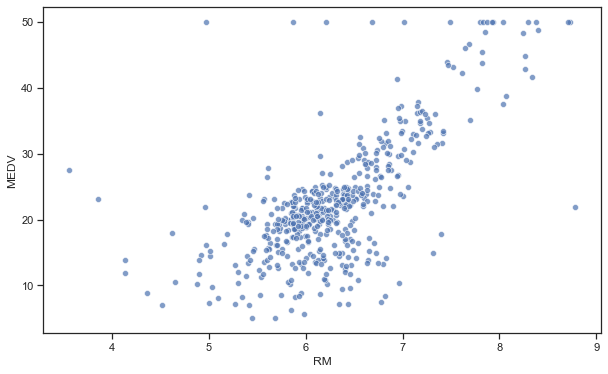

In [3]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df.RM, y=df.MEDV, alpha=0.7)
plt.show()

少し余談ですが、`sns.regplot()`を使うと、線形回帰の直線も合わせて確認できます。

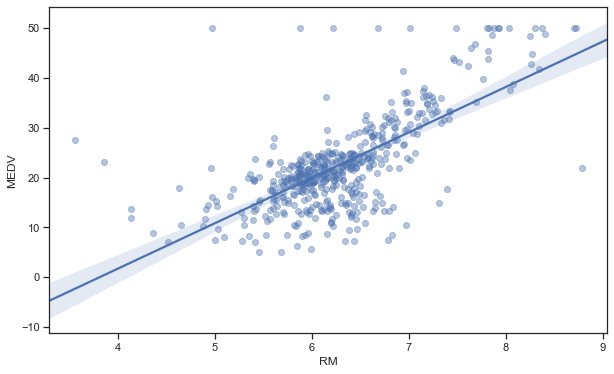

In [4]:
plt.figure(figsize=(10, 6))
sns.regplot(x=df.RM, y=df.MEDV, scatter_kws={'alpha': 0.4})
plt.show()

こんな感じですね。直線でもうまく予測できていそうですが、「若干捉えきれていないかな」といった印象です。

### 2.3 データの準備

多項式モデルを使うための準備をしていきます。特徴量はRM、予測対象はMEDVですね。これを、`train_test_split()`で学習用データとテスト用データに分割します。

In [5]:
x = df['RM']
X = np.array(x).reshape(-1, 1)
y = df['MEDV']

print('-'*10 + '特徴量とターゲットに分割' + '-'*10)
print('X:', X.shape)
print('y:', y.shape)

----------特徴量とターゲットに分割----------
X: (506, 1)
y: (506,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### 2.4 多項式モデルの作成

多項式モデルを作成するには、以下の手順が必要です。

- ①二次元の特徴量を作成する
- ②線形回帰と同じ手順でモデルを作る

今回ポイントになるのが、「①二次元の特徴量を作成する」ですね。

これはなんのことを言っているのかというと、$y = w_0 +  w_1 x + w_2 x^2$の$x^2$に当たる部分を作成するということです。つまり、RMを二乗した値を求めてから、多項式モデルを作成することになります。

<br/>

特徴量の二乗値を計算するには、`PolynomialFeatures()`を利用します。

In [7]:
pf = PolynomialFeatures(degree=2, include_bias=False)
X_train_2 = pf.fit_transform(X_train)
X_test_2 = pf.fit_transform(X_test)

In [8]:
print('元のRM：')
print(X_train[:5])
print('二乗したRM：')
print(X_train_2[:5])

元のRM：
[[6.951]
 [5.961]
 [6.897]
 [6.012]
 [5.304]]
二乗したRM：
[[ 6.951    48.316401]
 [ 5.961    35.533521]
 [ 6.897    47.568609]
 [ 6.012    36.144144]
 [ 5.304    28.132416]]


上記のように、`X_train_2`には、RMを二乗したデータが一緒に格納されています。これを使ってあげれば、多項式モデルを作成できますね。

In [9]:
# モデルの作成
lm = LinearRegression()
lm.fit(X_train_2,y_train)

# パラメータを表示
print('バイアス', lm.intercept_)
print('重み', lm.coef_)

#精度を表示
print('Train Score：{:.2f}' .format(lm.score(X_train_2, y_train)))
print('Test Score：{:.2f}' .format(lm.score(X_test_2, y_test)))

バイアス 68.20229885775146
重み [-23.56509374   2.56037958]
Train Score：0.56
Test Score：0.51


上記のような結果になりました。

数式で表すと、以下のようなモデルが完成したことになります。

$$y = 68.202 - 23.565 x + 2.5604 x^2$$


ちなみに、単回帰モデルで精度を確認すると、以下のようになっています。

In [10]:
# モデルの作成
tmp = LinearRegression()
tmp.fit(X_train,y_train)

y_pred_tmp = tmp.predict(X_test)

#精度を表示
print('Train Score：{:.2f}' .format(tmp.score(X_train, y_train)))
print('Test Score：{:.2f}' .format(tmp.score(X_test, y_test)))

Train Score：0.50
Test Score：0.42


多項式モデルの方が、学習結果と予測結果ともに精度が良くなっていますね。

### 2.5 学習結果の可視化

元データと予測結果を確認してみます。

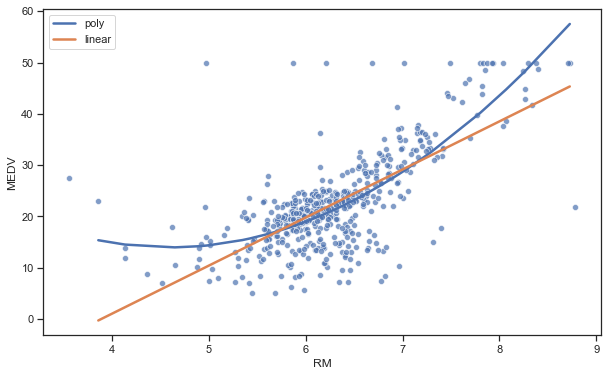

In [11]:
X_test_a = np.array([np.sort(X_test[:,0])]).reshape(len(X_test),1)
X_test_2 = pf.fit_transform(X_test_a)

y_pred = lm.predict(X_test_2)

plt.figure(figsize=(10, 6))
sns.scatterplot(X.reshape(len(X), ), y, alpha=0.7)
sns.lineplot(x=X_test_a.reshape(len(X_test_a), ), y=y_pred, linewidth=2.5, label='poly')
sns.lineplot(x=X_test.reshape(len(X_test), ), y=y_pred_tmp, linewidth=2.5, label='linear')
plt.xlabel('RM')
plt.ylabel('MEDV')
plt.show()

可視化してみても、曲線の方が正しく予測できている気がしますね。

In [12]:
#notebookをpythonファイルに変換
# ! jupyter nbconvert --to script ml05_polynomial_model.ipynb

### 2.6 多項式モデルの次元を上げる

今回は、単回帰モデルから二次元にすることで、モデルの精度が向上しました。

それでは、次元を上げれば上げるほど、モデルの精度は良くなるのでしょうか？

以下おまけで、次元を上げたときの多項式モデル精度を確認しましょう。

In [13]:
def get_polynomial_features(degree:int, data):
    pf = PolynomialFeatures(degree=degree, include_bias=False)
    return pf.fit_transform(data)

In [14]:
# 二次元(今回取り扱ったモデル)
X_train_2 = get_polynomial_features(2, X_train)
X_test_2 = get_polynomial_features(2, X_test)

# 五次元
X_train_5 = get_polynomial_features(5, X_train)
X_test_5 = get_polynomial_features(5, X_test)

# 十次元
X_train_10 = get_polynomial_features(10, X_train)
X_test_10 = get_polynomial_features(10, X_test)

In [15]:
# モデルの作成
lm_2deg = LinearRegression()
lm_2deg.fit(X_train_2,y_train)

# モデルの作成
lm_5deg = LinearRegression()
lm_5deg.fit(X_train_5,y_train)

# モデルの作成
lm_10deg = LinearRegression()
lm_10deg.fit(X_train_10,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [16]:
#精度を表示
print('-'*10 + '二次元モデルの精度' + '-'*10)
print('Train Score：{:.2f}' .format(lm_2deg.score(X_train_2, y_train)))
print('Test Score：{:.2f}' .format(lm_2deg.score(X_test_2, y_test)))

#精度を表示
print('-'*10 + '五次元モデルの精度' + '-'*10)
print('Train Score：{:.2f}' .format(lm_5deg.score(X_train_5, y_train)))
print('Test Score：{:.2f}' .format(lm_5deg.score(X_test_5, y_test)))

#精度を表示
print('-'*10 + '十次元モデルの精度' + '-'*10)
print('Train Score：{:.2f}' .format(lm_10deg.score(X_train_10, y_train)))
print('Test Score：{:.2f}' .format(lm_10deg.score(X_test_10, y_test)))

----------二次元モデルの精度----------
Train Score：0.56
Test Score：0.51
----------五次元モデルの精度----------
Train Score：0.61
Test Score：0.50
----------十次元モデルの精度----------
Train Score：0.61
Test Score：0.45


上記のように、モデルの次元を上げれば上げるほど、テストデータに対する当てはまりが悪くなってしまいました。

つまり、訓練用データに対して過剰に適合してしまっている状態で、これを**過学習(Over Fitting)**と呼びます。

モデルを複雑にしすぎると、未知のデータに対応できなくなるんですね。

次回は、この過学習の対策方法を紹介していきます。